# 프로젝트 : This is your playground! Leaderboard

### 튜닝해볼 수 있는 모델 클래스 인자

**대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자**

- max_depth : 의사 결정 나무의 깊이, 정수 사용
- learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
- n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
- num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
- boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

### 시도해볼 수 있는 방법
- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기

### 데이터 이해하기
ID : 집을 구분하는 번호
date : 집을 구매한 날짜
price : 타겟 변수인 집의 가격
bedrooms : 침실의 수
bathrooms : 침실당 화장실 개수
sqft_living : 주거 공간의 평방 피트
sqft_lot : 부지의 평방 피트
floors : 집의 층수
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
view : 집이 얼마나 좋아 보이는지의 정도
condition : 집의 전반적인 상태
grade : King County grading 시스템 기준으로 매긴 집의 등급
sqft_above : 지하실을 제외한 평방 피트
sqft_basement : 지하실의 평방 피트
yr_built : 집을 지은 년도
yr_renovated : 집을 재건축한 년도
zipcode : 우편번호
lat : 위도
long : 경도
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 학습 데이터와 테스트 데이터 합치기

- 데이터를 pd.concat을 이용해서 합친다.
- 모델 학습 진행시에 다시 분리해서 사용해야 하기 때문에 데이터를 합치기 전 train_len에 training data의 개수를 저장해서 추후에 학습데이터만 불러올 수 있는 인덱스로 사용한다.

In [8]:
# train, sub 데이터프레임 통합
train_len = len(train)
data = pd.concat((train, sub))
print(train_len)

15035


In [9]:
# date 열 전처리
data['date'] = data['date'].apply(lambda i: i[:8]).astype(int)

<AxesSubplot:>

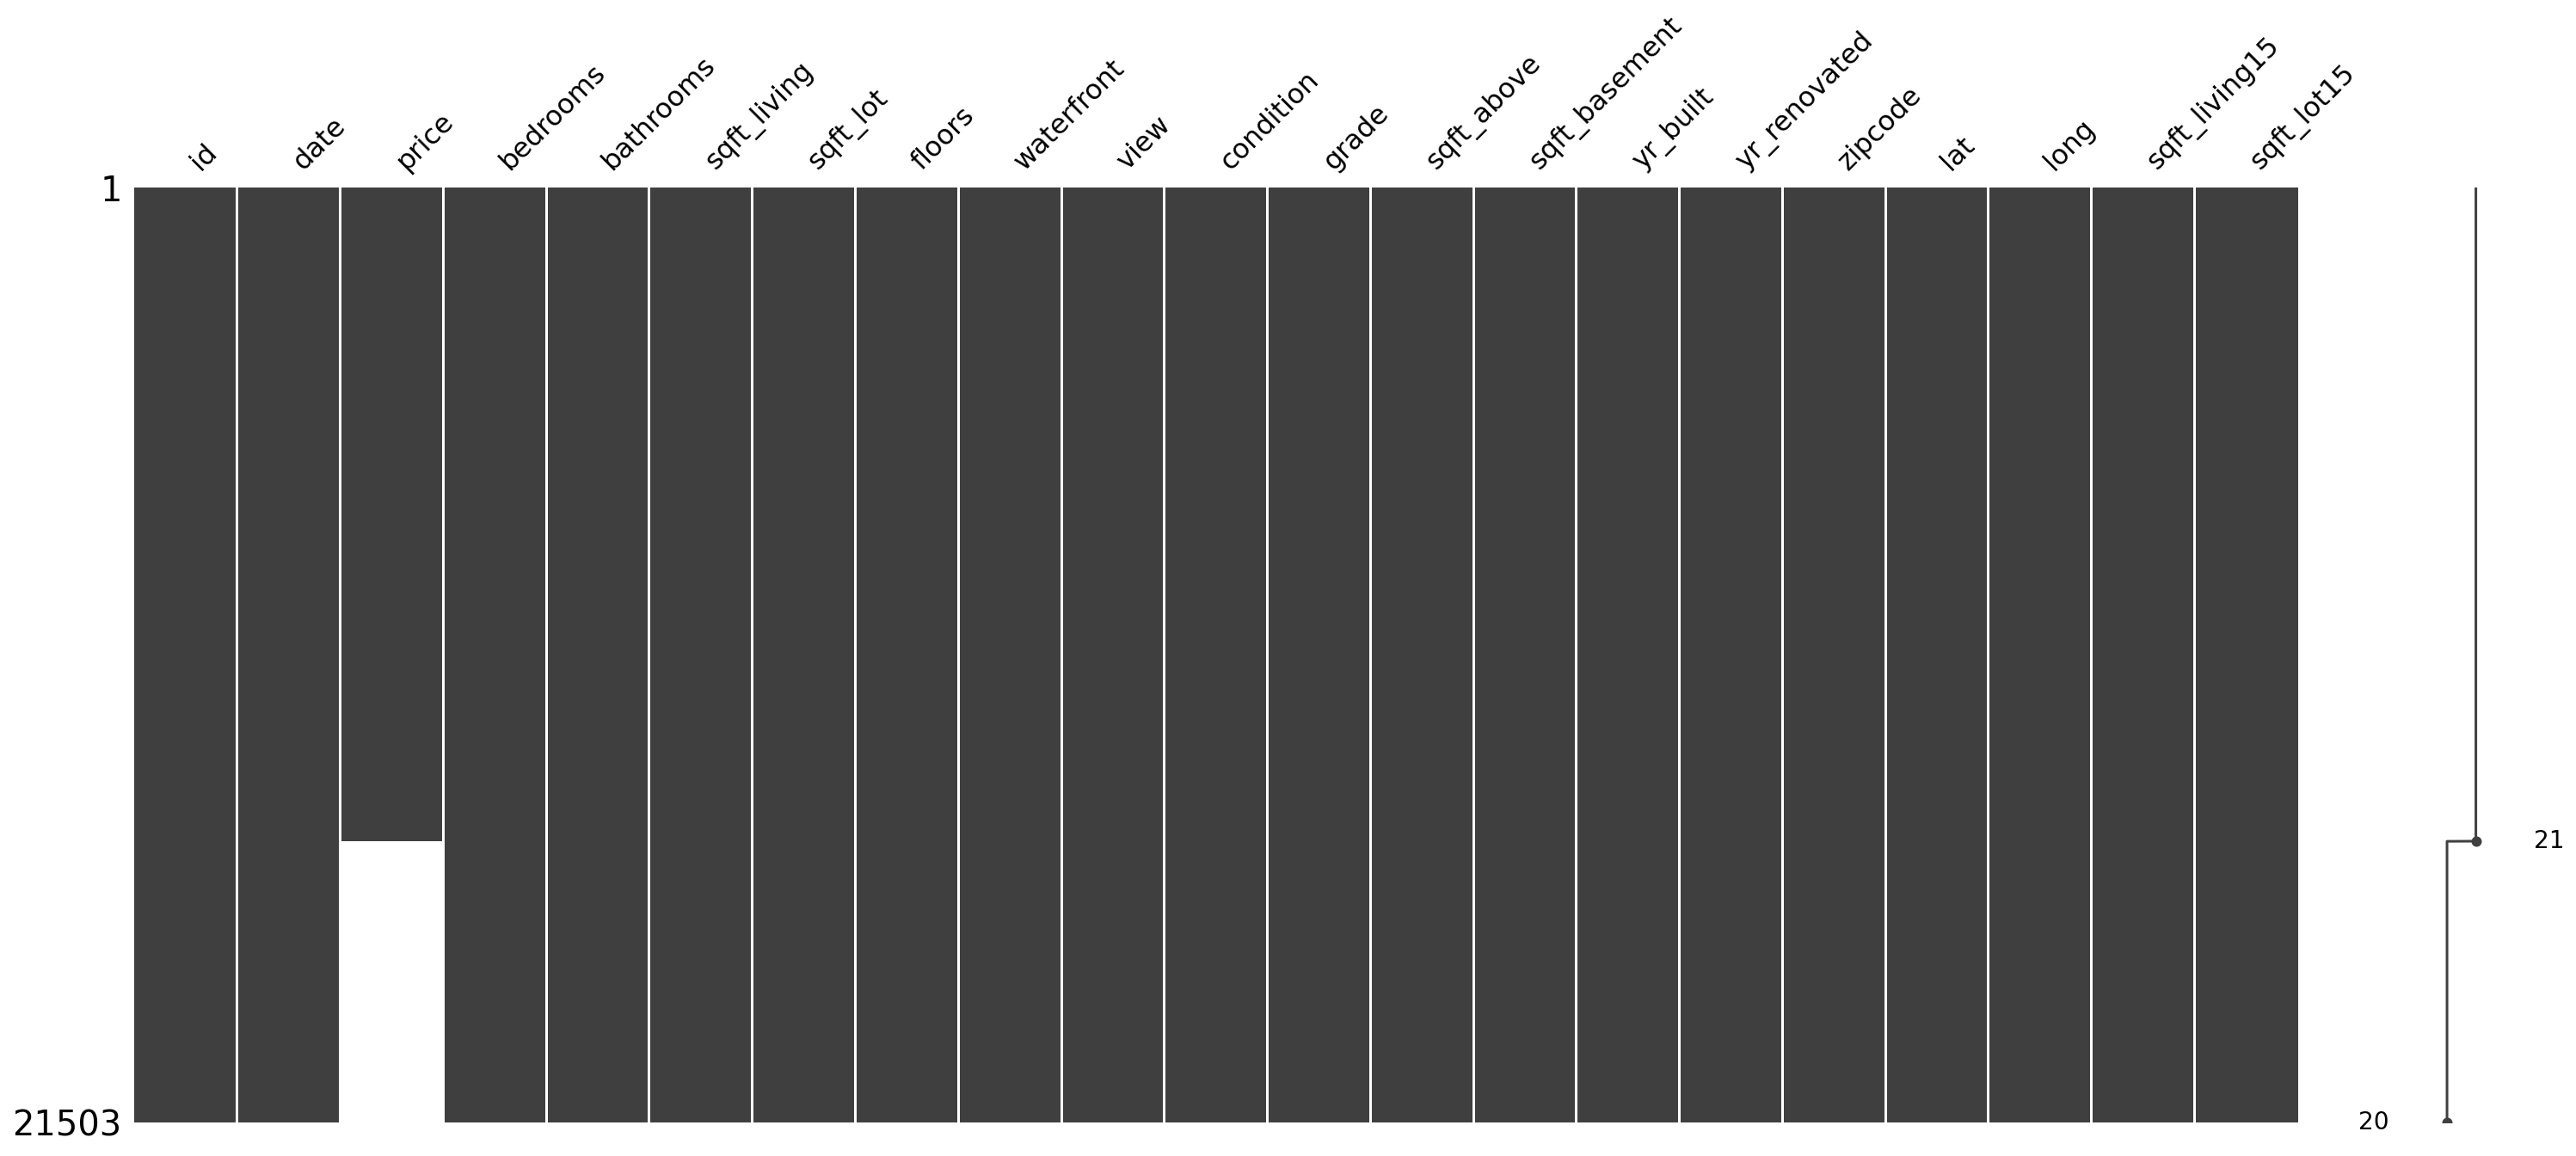

In [6]:
# 결측치 확인
msno.matrix(data)

### 각 변수들의 분포 확인
전체 데이터들의 분포를 확인한다. 특히 너무 치우친 분포를 가지는 컬럼의 경우 모델이 결과를 예측하는 데에 좋지 않은 영향을 미치므로 다듬는 작업을 한다. 

시각화 코드를 통해 id 컬럼을 제외한 19개 컬럼에 대해 한 번에 모든 그래프를 그려준다. 
그래프의 종류는 sns.kdeplot을 사용한다. kdeplot은 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 하는 시각화 함수이다.

In [10]:
data.shape

(21503, 21)

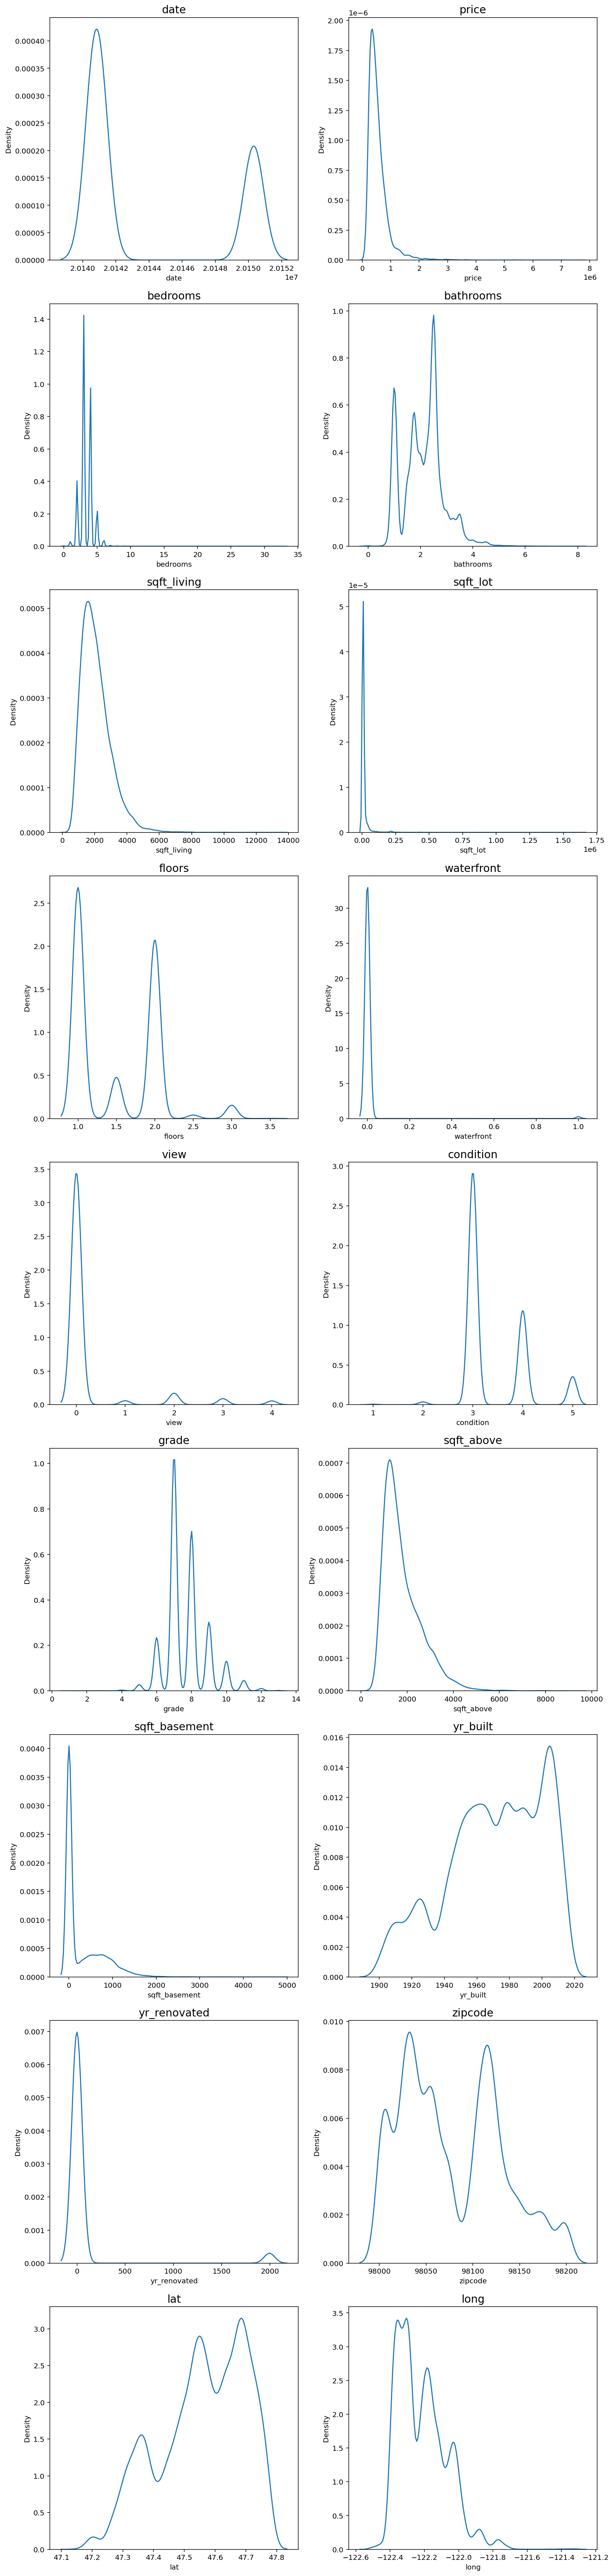

In [11]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 21 :
            break
plt.tight_layout()

bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우친 경향을 보인다.
한 쪽으로 치우친 분포의 경우에는 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포에 가깝게 만들 수 있다. 

치우친 컬럼들을 skew_columns 리스트 안에 담고, 모두 np.log1p()를 활용해서 로그 변환을 해준다. numpy.log1p() 함수는 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수이다.

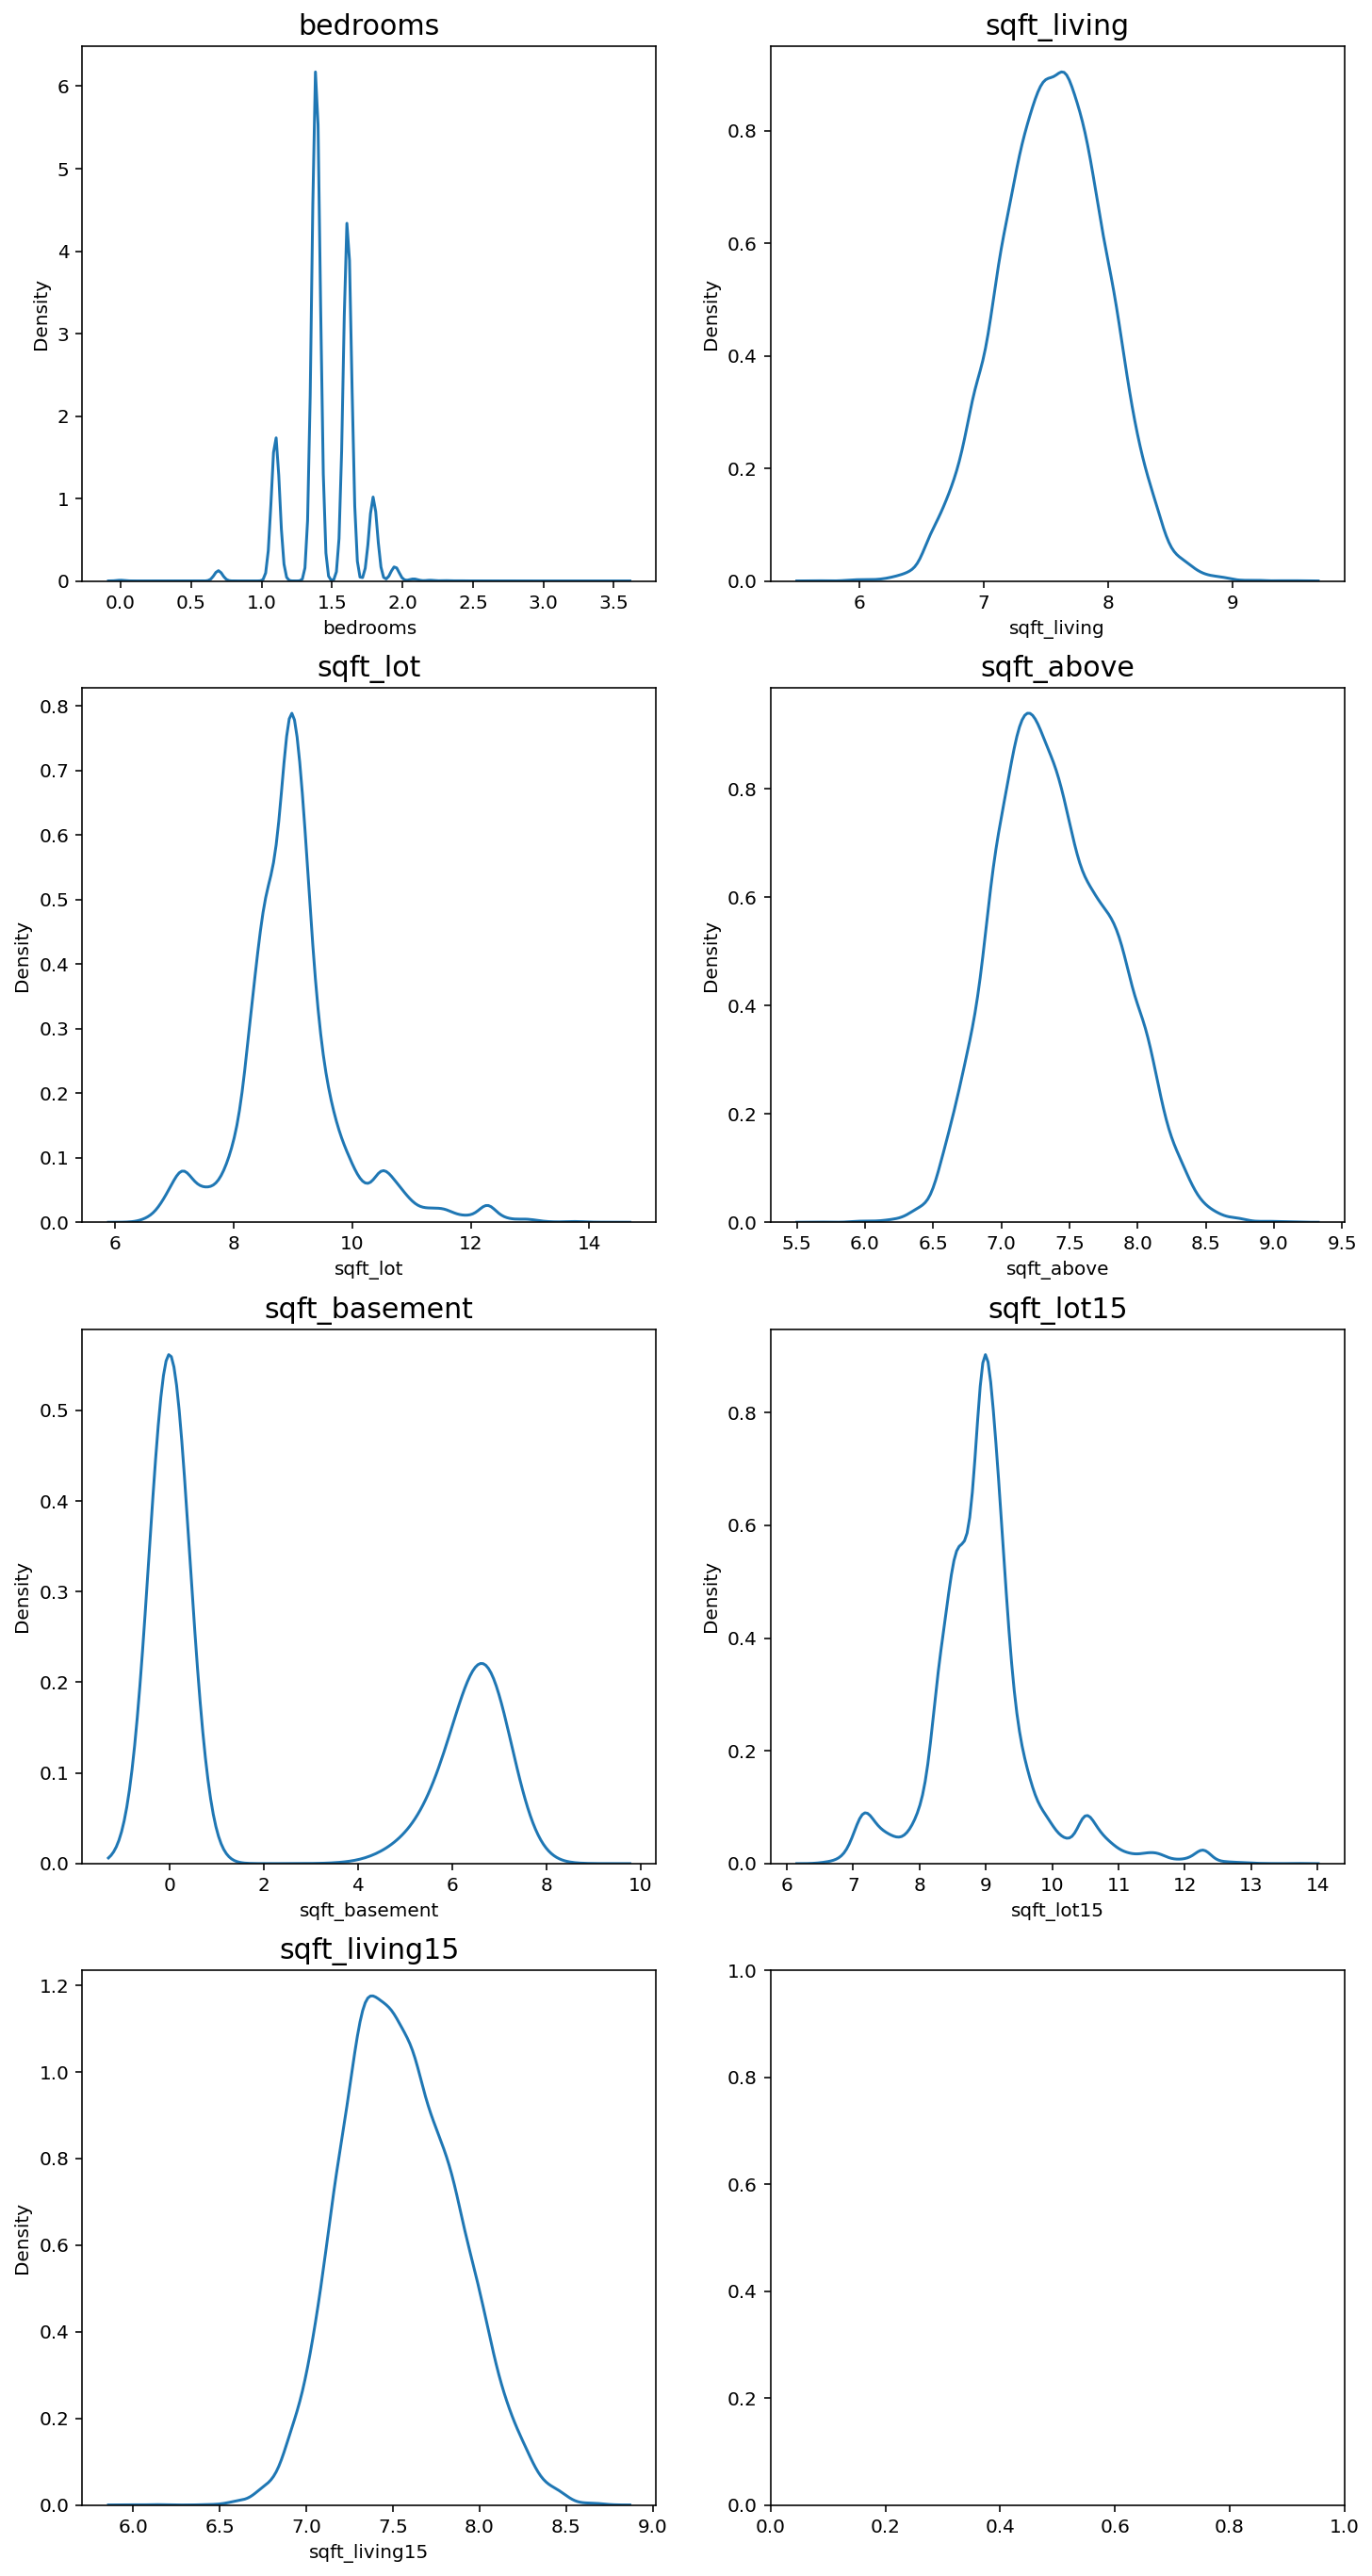

In [12]:
# 치우친 분포를 log 변환
skew_columns = ['bedrooms', 'sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_lot15','sqft_living15']

for c in skew_columns:
  data[c] = np.log1p(data[c].values)

fig, ax = plt.subplots(4,2,figsize=(12,24))

count=0
for row in range(4):
  for col in range(2):
    if count == 7: break
    sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
    ax[row][col].set_title(skew_columns[count],fontsize=15)
    count+=1

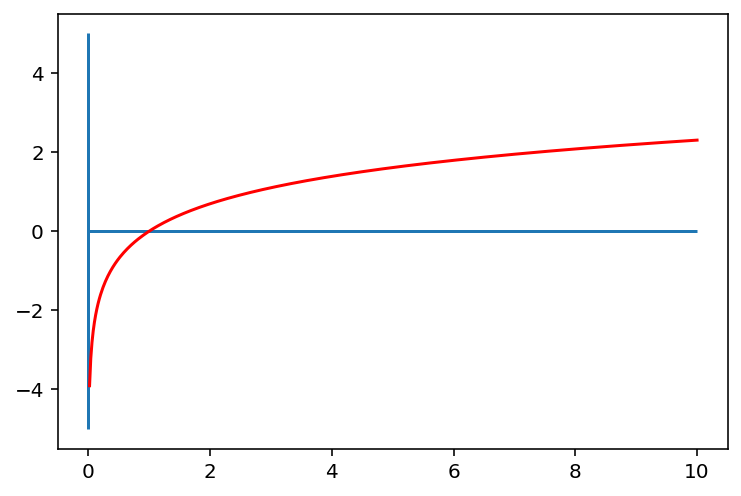

In [13]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

### 데이터 분리

In [14]:
# train, sub 데이터셋으로 분리
train = data.iloc[:train_len, :]
sub = data.iloc[train_len:, :]
del sub['price']

<AxesSubplot:xlabel='price', ylabel='Density'>

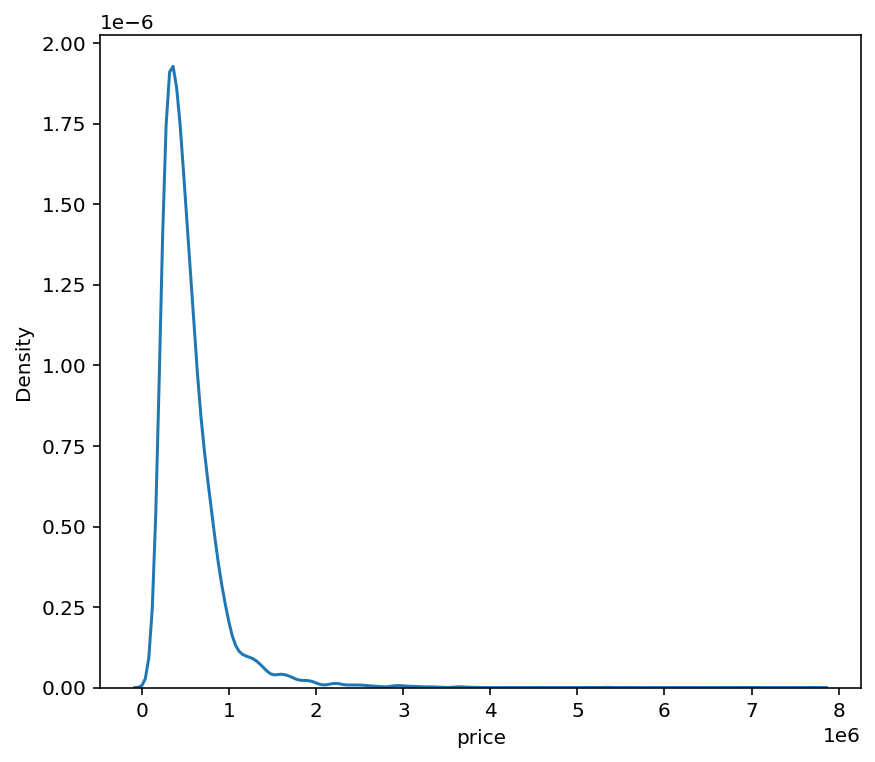

In [15]:
# target data인 가격 분포 확인
fig = plt.figure(figsize=(15,6))

fig.add_subplot(1,2,1)
sns.kdeplot(train['price'])


<AxesSubplot:xlabel='price', ylabel='Density'>

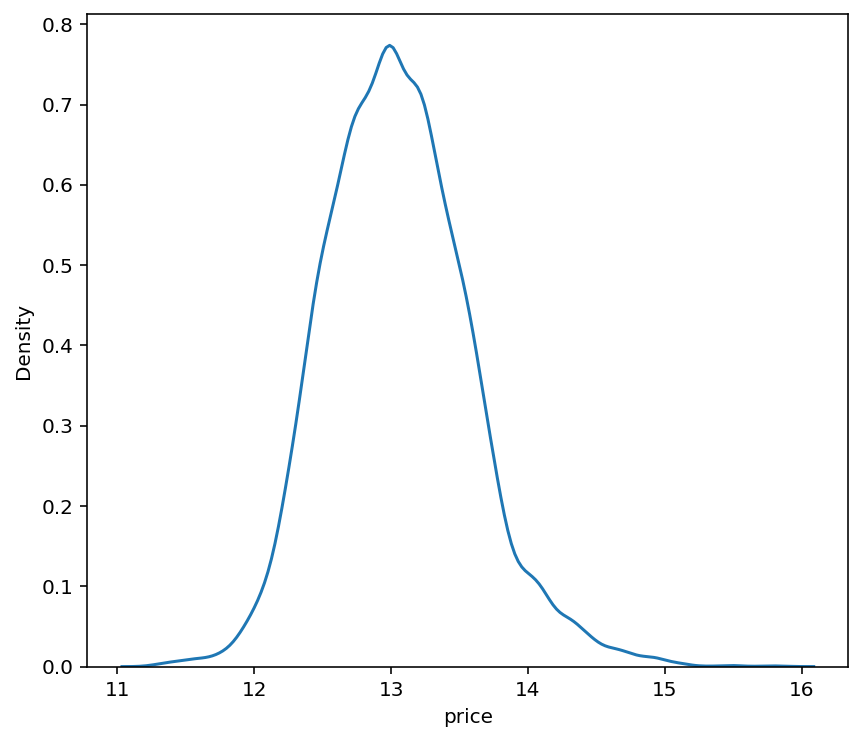

In [16]:
# train['price'] 로그변환
train['price'] = np.log1p(train['price'])

fig = plt.figure(figsize=(15,6))

fig.add_subplot(1,2,1)
sns.kdeplot(train['price'])

### 변수 시각화
**변수들간의 상관관계 시각화**

In [17]:
train.corr()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.013257,0.035940,0.009122,0.104030,0.041591,-0.137545,0.182848,-0.011775,-0.024360,...,0.078622,0.073175,-0.039064,0.202477,-0.029810,-0.005761,0.002588,0.014757,0.023982,-0.130312
date,-0.013257,1.000000,0.009426,-0.001848,-0.022830,-0.021202,-0.000977,-0.020909,-0.001713,0.014012,...,-0.023272,-0.017599,-0.002265,0.004494,-0.019593,-0.000778,-0.031714,0.002881,-0.013189,-0.002200
price,0.035940,0.009426,1.000000,0.356086,0.552000,0.677383,0.145465,0.317810,0.172580,0.347506,...,0.707412,0.591185,0.231982,0.076293,0.127533,-0.039195,0.444417,0.054362,0.609042,0.128528
bedrooms,0.009122,-0.001848,0.356086,1.000000,0.531728,0.654434,0.195001,0.195270,-0.008997,0.076801,...,0.389402,0.549797,0.192605,0.184313,0.015862,-0.178626,-0.023418,0.150666,0.429871,0.173739
bathrooms,0.104030,-0.022830,0.552000,0.531728,1.000000,0.762770,0.100960,0.508649,0.075452,0.187488,...,0.666278,0.697572,0.185446,0.503964,0.065423,-0.207500,0.018110,0.227669,0.575099,0.093674
sqft_living,0.041591,-0.021202,0.677383,0.654434,0.762770,1.000000,0.326958,0.376024,0.083036,0.242719,...,0.744805,0.867473,0.277304,0.348704,0.058676,-0.223746,0.036476,0.260941,0.746969,0.303916
sqft_lot,-0.137545,-0.000977,0.145465,0.195001,0.100960,0.326958,1.000000,-0.232084,0.077558,0.126415,...,0.187930,0.317639,-0.018134,-0.003294,0.020572,-0.279549,-0.144338,0.375436,0.366494,0.917834
floors,0.182848,-0.020909,0.317810,0.195270,0.508649,0.376024,-0.232084,1.000000,0.031159,0.034511,...,0.462598,0.552572,-0.264388,0.490436,0.009752,-0.059107,0.049004,0.126983,0.281866,-0.220965
waterfront,-0.011775,-0.001713,0.172580,-0.008997,0.075452,0.083036,0.077558,0.031159,1.000000,0.389669,...,0.088061,0.067640,0.040272,-0.026523,0.104168,0.028632,-0.014772,-0.037922,0.083078,0.082652
view,-0.024360,0.014012,0.347506,0.076801,0.187488,0.242719,0.126415,0.034511,0.389669,1.000000,...,0.247924,0.158828,0.194127,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.261029,0.121276


['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

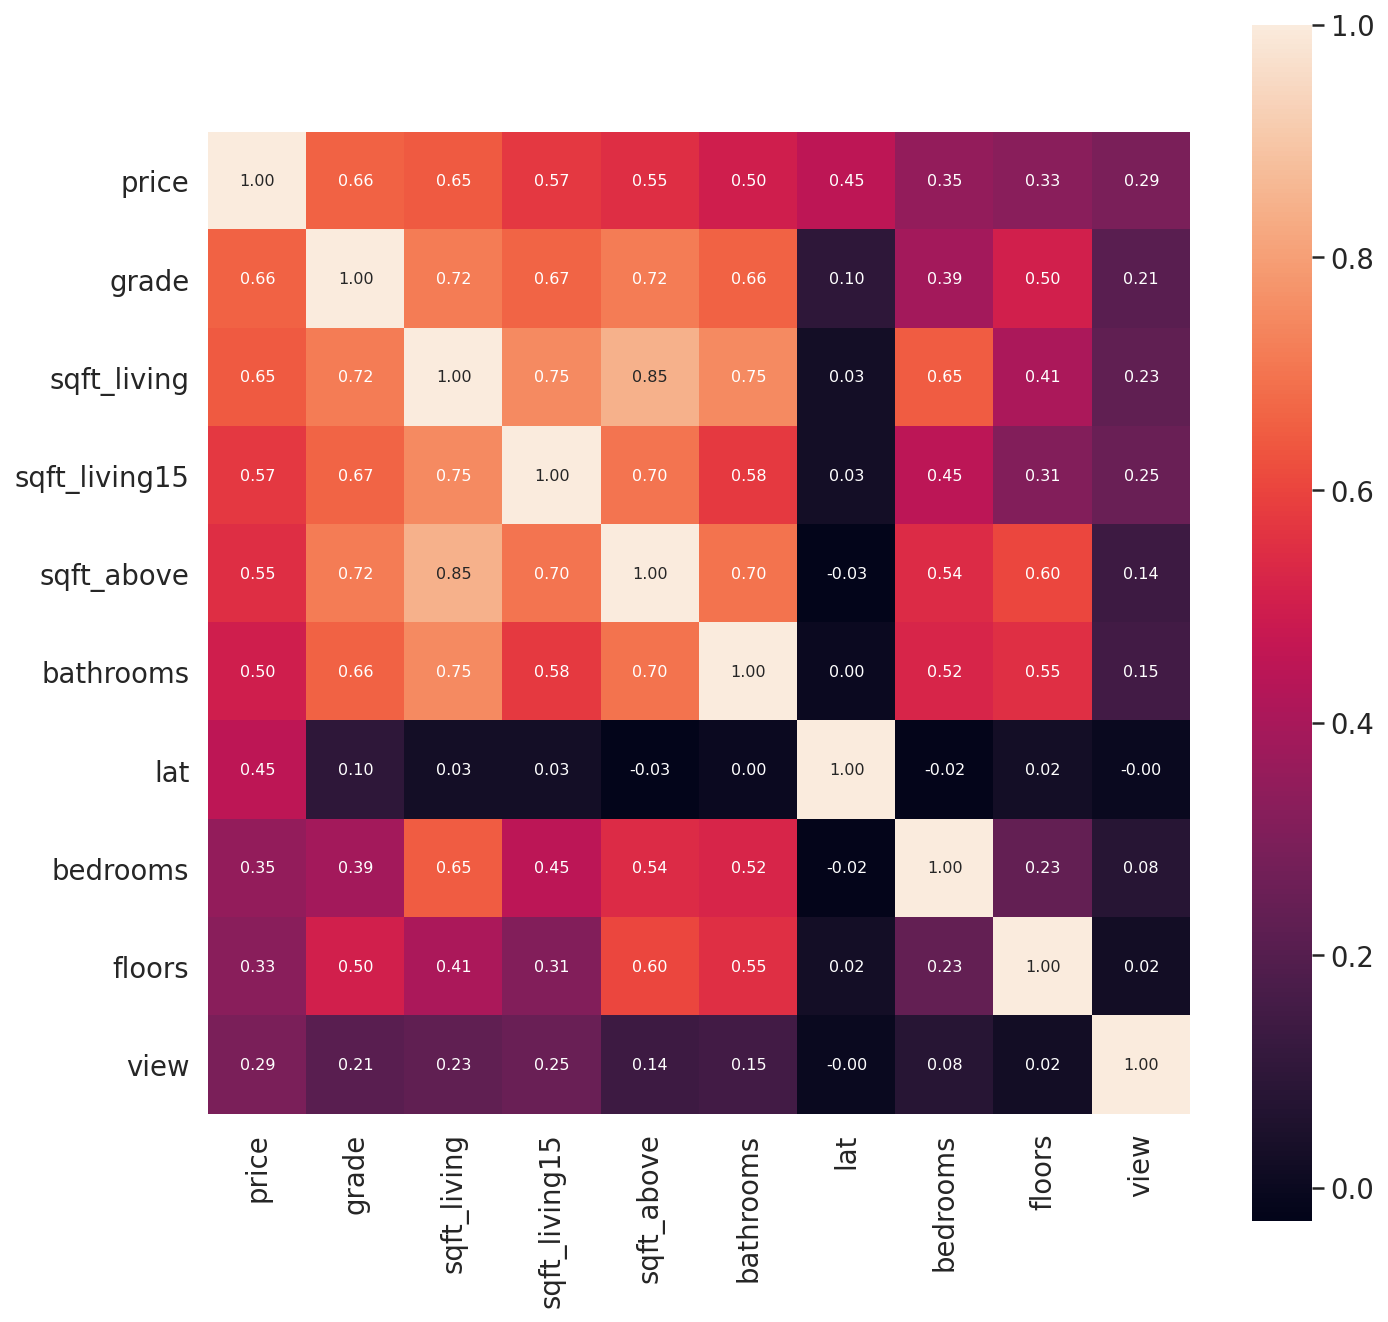

In [18]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='price').index

cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0]
print(cor_cols.values)
plt.figure(figsize=(11,11))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [19]:
corr = train.corr()
corr = corr.sort_values('price', ascending = False)
corr['price'].head(6)  # 첫번째는 price 자기 자신이므로 제외

price            1.000000
grade            0.707412
sqft_living      0.677383
sqft_living15    0.609042
sqft_above       0.591185
bathrooms        0.552000
Name: price, dtype: float64

In [20]:
# target 변수인 price를 저장
y = train['price']

del train['id']
del train['price']
del sub['id']

In [21]:
print(train.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  float64
 18  sqft_l

In [23]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,20150225,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,20150218,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,20140627,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,20150115,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


In [24]:
sub.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141209,1.386294,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1991,98125,47.7210,-122.319,7.433075,8.941153
1,20141209,1.609438,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,0,98136,47.5208,-122.393,7.215975,8.517393
2,20140512,1.609438,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,0,98053,47.6561,-122.005,8.468213,11.532051
3,20150415,1.386294,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,0,98146,47.5123,-122.337,7.484930,9.001346
4,20150312,1.386294,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,0,98038,47.3684,-122.031,7.779467,8.932080


### 모델학습

### 1) RMSE

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [26]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [27]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [28]:
random_state=2021

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [29]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [30]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 136318.17037533253,
 'XGBRegressor': 131079.1752388878,
 'LGBMRegressor': 128587.01873332736,
 'RandomForestRegressor': 136668.48511057728}

In [31]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
RandomForestRegressor,136668.485111
GradientBoostingRegressor,136318.170375
XGBRegressor,131079.175239
LGBMRegressor,128587.018733


### GridSearchCV

In [39]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
  grid_model = GridSearchCV(model, param_grid = param_grid,\
                          scoring='neg_mean_squared_error', \
                          cv=5, verbose=verbose, n_jobs=n_jobs)

  grid_model.fit(train, y)

  params = grid_model.cv_results_['params']
  score = grid_model.cv_results_['mean_test_score']

  results = pd.DataFrame(params)
  results['score'] = score
  results["RMSLE"] = np.sqrt(-1 * results['score'])
  results = results.sort_values("RMSLE")

  return results

In [42]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10, 20],
    'learning_rate': [0.05, 0.1],
    'boosting_type': ['gbdt', 'rf', 'dart', 'goss']
}


model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:   15.1s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,boosting_type,learning_rate,max_depth,n_estimators,score,RMSLE
11,gbdt,0.10,20,100,-0.026927,0.164095
9,gbdt,0.10,10,100,-0.027033,0.164418
45,goss,0.10,10,100,-0.027233,0.165024
47,goss,0.10,20,100,-0.027335,0.165333
41,goss,0.05,20,100,-0.028563,0.169005
39,goss,0.05,10,100,-0.028602,0.169121
46,goss,0.10,20,50,-0.028945,0.170132
5,gbdt,0.05,20,100,-0.028945,0.170132
44,goss,0.10,10,50,-0.028983,0.170243
3,gbdt,0.05,10,100,-0.029083,0.170536


최적의 파라미터로 구성된 모델을 학습시키고 예측된 값을 csv 파일로 저장하는 save_submission 함수를 정의

In [48]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [49]:
save_submission(model, train, y, sub, 'lgbm', rmsle='0.1644')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.1644.csv saved!


스코어 : 114537.07028